# Weights and Biases

Goal: Train on CIFAR10 and do good by systematically finding better and better hyperparameters

Note: I ran this on colab to train faster, which required me to remove some of the unusual typing stuff going on in "resenet.py" (yes spelled wrong).

## Set up groundwork

In [5]:
import torch as t
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fancy_einsum import einsum
from typing import Union, Optional, Callable
import numpy as np
from einops import rearrange
from tqdm.notebook import tqdm_notebook
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import time
import wandb
import utilsD1 as utils

device = "cuda" if t.cuda.is_available() else "cpu"

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



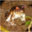
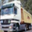
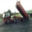
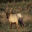
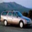
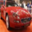
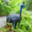
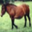
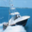
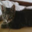
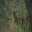
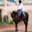
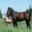
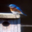
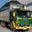

In [6]:
# from tutorial
cifar_mean = [0.485, 0.456, 0.406]
cifar_std = [0.229,0.224,0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

utils.show_cifar_images(trainset, rows=3, cols=5)

In [17]:
from typing import Union

In [25]:
import resenet as myresnet

resnet = myresnet.ResNet34()


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Sequential(
  (0): Conv2d(weights shape = torch.Size([10, 3, 3, 3]) stride = (1, 1) padding = (0, 0) )
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
)


In [ ]:
utils.show_cifar_images(trainset, rows=1, cols=1)

In [34]:
import resenet as myresnet

def train(trainset, testset, epochs: int, loss_fn: Callable, batch_size: int, lr: float):

    model = myresnet.ResNet34().to(device).train()
    optimizer = t.optim.Adam(model.parameters(), lr=lr)

    loss_list = []
    accuracy_list = []

    trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
    testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

    for epoch in range(epochs):

        progress_bar = tqdm_notebook(trainloader)

        for (x, y) in progress_bar:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

            progress_bar.set_description(f"Epoch = {epoch}, Loss = {loss.item():.4f}")

        with t.inference_mode():

            accuracy = 0
            total = 0

            for (x, y) in testloader:

                x = x.to(device)
                y = y.to(device)

                y_hat = model(x)
                y_predictions = y_hat.argmax(1)
                accuracy += (y_predictions == y).sum().item()
                total += y.size(0)

            accuracy_list.append(accuracy/total)

        print(f"Epoch {epoch+1}/{epochs}, train loss is {loss:.6f}, accuracy is {accuracy}/{total}")

    filename = "./w0d3_resnet.pt"
    print(f"Saving model to: {filename}")
    t.save(model.state_dict(), filename)

    utils.plot_results(loss_list, accuracy_list)
    return loss_list, accuracy_list

epochs = 1
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
lr = 0.001

loss_list, accuracy_list = train(trainset, testset, epochs, loss_fn, batch_size, lr)

  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [35]:
epochs = 1
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
lr = 0.001

In [38]:
# train loop with wandb logging AND sweeping!

def train() -> None:

    wandb.init()
    epochs = wandb.config.epochs
    batch_size = wandb.config.batch_size
    lr = wandb.config.lr


    model = myresnet.ResNet34().to(device).train()
    optimizer = t.optim.Adam(model.parameters(), lr=lr)

    examples_seen = 0
    start_time = time.time()

    trainloader = DataLoader(trainset, shuffle=True, batch_size = batch_size)
    testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

    wandb.watch(model, criterion=loss_fn, log="all", log_freq=10, log_graph=True)

    for epoch in range(epochs):

        progress_bar = tqdm_notebook(trainloader)

        for (x,y) in progress_bar:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            progress_bar.set_description(f"Epoch = {epoch}, Loss = {loss.item():.4f}")

            examples_seen += len(x)
            wandb.log({"train_loss": loss, "elapsed": time.time() - start_time}, step=examples_seen)
        with t.inference_mode():

            accuracy = 0
            total = 0

            for (x,y) in testloader:
                x = x.to(device)
                y = y.to(device)

                y_hat = model(x)
                y_predictions = y_hat.argmax(1)
                accuracy += (y_predictions == y).sum().item()
                total += y.size(0)

            wandb.log({"test_accuracy": accuracy/total}, step=examples_seen)

    filename = f"{wandb.run.dir}/model_state_dict.pt"
    print(f"Saving model to: {filename}")
    t.save(model.state_dict(), filename)
    wandb.save(filename)

sweep_config = {
    'method': 'random',
    'name': 'w2d1_resnet_sweep_2',
    'metric': {'name': 'test_accuracy', 'goal': 'maximize'},
    'parameters': 
    {
        'batch_size': {'values': [64, 128, 256]},
        'epochs': {'min': 1, 'max': 3},
        'lr': {'max': 0.1, 'min': 0.0001, 'distribution': 'log_uniform_values'}
     }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='w2d1_resnet')
wandb.agent(sweep_id=sweep_id, function=train, count = 2)


Create sweep with ID: in9j31um
Sweep URL: https://wandb.ai/starship006/w2d1_resnet/sweeps/in9j31um


wandb: Agent Starting Run: n370ihzk with config:
wandb: 	batch_size: 128
wandb: 	epochs: 2
wandb: 	lr: 0.003219283853806571


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saving model to: /content/wandb/run-20221106_015026-n370ihzk/files/model_state_dict.pt


elapsed,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁█
train_loss,█▆▆▆▄▅▅▄▄▅▄▄▃▃▄▃▄▃▂▂▂▃▄▂▂▄▃▃▁▃▁▂▂▁▁▁▂▁▁▁
elapsed,157.72443
test_accuracy,0.5495
train_loss,1.37077


wandb: Agent Starting Run: umn7el6g with config:
wandb: 	batch_size: 128
wandb: 	epochs: 1
wandb: 	lr: 0.0022312149153311325


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


  0%|          | 0/391 [00:00<?, ?it/s]

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saving model to: /content/wandb/run-20221106_015322-umn7el6g/files/model_state_dict.pt


elapsed,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
train_loss,█▄▄▄▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▃▃▁▁▂▂▂▁▁▂▁▂▁▁▁
elapsed,75.75265
test_accuracy,0.5633
train_loss,1.10604
